<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Practical filters for Audio Processing</p>

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal

import import_ipynb
from FilterUtils import *

importing Jupyter notebook from FilterUtils.ipynb


In [3]:
plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 14})

In [4]:
DEFAULT_SF = 16000

# Introduction

In this notebook we will explore a complete set of "recipes" to design second-order digital IIR filters. The transfer function of a generic second-order section (also known as a **biquad**) has the canonical form
$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}}
$$

The routines defined in the rest of this notebook will allow you to compute the values of the five biquad parameters in order to implement a variety of different filter prototypes according to the desired specifications. We will also explore how to cascade second-order sections to implement higher-order filters with improved characteristics. 

## Common practices

Although ultimately we will design digital filters, in audio applications it is important to become familiar with the main ideas behind _analog_ filter design and analysis; indeed, audio recording and production techniques have been developed and fine-tuned well before the advent of DSP and, even in today's world of DAWs, the language and many of the practices in current use still reflect the analog conventions of yore.

In particular:
 * filter specifications are almost always expressed in terms of real-world frequencies in Hz rather than as normalized frequencies over $[-\pi, \pi]$; this of course implies that the underlying sampling frequency is known
 * plots of the magnitude response will usually be shown on a log-log graph, generally using a decibel scale for the amplitde and a decade scale for frequencies; this mirrors the way in which  human audio perception is approximately logarithmic both in frequency and in scale.
 
The companion notebook ``FilterUtils.ipynb`` implements a set of plotting routines that take these conventions into account. For example, this is how the magnitude response of the same leaky integrator looks like in the typical representations used in communication systems vs. audio equalization:

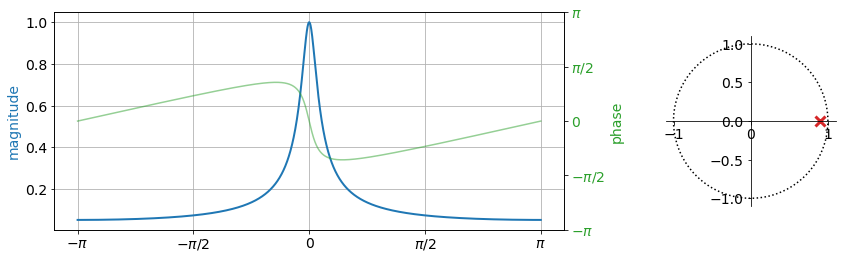

In [5]:
lam = 0.9
filter_props([1 - lam], [1, -lam])

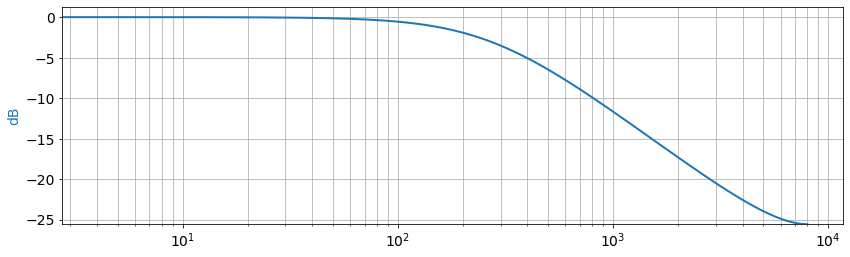

In [6]:
analog_response([1 - lam], [1, -lam], DEFAULT_SF, dB=-50)

# The biquad design strategy

The next section provides a set of functions to compute the five biquad filter coefficients for a desired response (lowpass, bandpass, etc) and an associated set of specifications (cutoff, attenuation, etc). Rather than tackling the search for the coefficients as an abstract optimization problem, each recipe starts from a well-known _analog_ second-order filter with the desired characteristic, and then converts it to a discrete-time filter using a mapping called the _bilinear transform_ .

The reason for this approach is that the classic analog filter prototypes (Butterworth, Chebyshev, etc.) (and the topologies used for their implementation) are extremely well understood and have proven extremely reliable over more than a century of research and practical experimentation. 

## The analog prototypes

<img src="img/rlc.png" alt="rlc" style="float: right; width: 200px; margin: 0 10px 10px 30px;"/>

Historically, the development of electronic filters began with the design of **passive** analog filters, that is, filters using only resistors, capacitors and inductors; indeed, an RLC circuit, that is, a network containing a resistor, a capacitor and an inductor, can implement the prototypical analog second-order section. Since these filters have no active elements that can provide signal amplification, the power of their output is at most equal to (but, in practice, smaller than) the power of the input. This implicitly guarantees the stability of these systems although, at least in theory, strong resonances can appear in the frequency response.

Analog filters work by exploiting the frequency-dependent reactance of capacitors and inductors. The input-output characteristic for linear circuits using these electronic components is described by linear differential equations, which implies the existence of some form of _feedback_ in the circuits themselves. As a consequence, when we convert the analog prototypes to digital realizations, we invariably end up with IIR filters. 

Passive filters operating in the frequency range of audio applications require the use of bulky inductors and therefore **active** filters are usually preferred in the analog domain. In the digital domain, on the other hand, we are in fact free to use arbitrary gain factors (it's just multiplications!) and so the resulting transfer functions can approximate either type of design. 

## The bilinear transform

The cookbook recipes below are obtained by mapping second-order analog filters prototypes to equivalent digital realization via the _bilinear transform_ . We will not go into full details but, as a quick reference, here are the main ideas behind the method. 

An analog filter is described by a transfer function $H(s)$, with $s\in \mathbb{C}$, which is the Laplace transform of the filter's continuous-time impulse response. The key facts about $H(s)$ are:
 * filter stability requires that all the poles of $H(s)$ lie in the left half of the complex plane (i.e. their real part must be negative)
 * the filter's frequency response is given by $H(j\Omega)$, that is, by the values of $H(s)$ along the imaginary axis

<img src="img/bilinear.png" alt="rlc" style="float: right; width: 300px; margin: 10px 0;"/>

The bilinear transform maps the complex $z$-plane (discrete time) to the complex $s$-plane (continuous time) as

$$
    s \leftarrow c \frac{1 - z^{-1}}{1 + z^{-1}} = \Phi_{c}(z)
$$

where $c$ is a real-valued constant. Given a stable analog filter $H(s)$, the transfer function of its discrete-time version is $H_d(z) = H(\Phi_{c}(z))$ and it is relatively easy to verify that
 * the inside of the unit circle on the $z$-plane is mapped to the left half of the $s$-plane, which preserves stability
 * the unit circle on the $z$-plane is mapped to the imaginary axis of the $s$-plane
 
The last property allows us to determine the frequency response of the digital filter as $H_d(e^{j\omega}) = H(\Phi_{c}(e^{j\omega})) = H(j\,c\tan(\omega/2))$, or: 

$$
    \Omega \leftarrow c\tan(\omega/2) %\omega \leftarrow 2\arctan(\Omega/c)
$$

we can see that $\omega=0$ is mapped to $\Omega=0$, $\omega=\pi/2$ is mapped to $\Omega=c$, and $\omega=\pi$ is mapped to $\Omega=\infty$, which reveals the high nonlinearity of the frequency mapping. We usually need to precisely control a least one notable point $H_d(e^{j\omega_0})$ in the frequency response of the discrete-time filter; for example, in a resonator, we need to place the magnitude peak at a specific frequency $\omega_0$. To achieve this, we design the analog filter so that $H(1j) = H_d(e^{j\omega_0})$ and then we set $c = 1/\tan(\omega_0/2)$ in the bilinear operator; this adjustment, called **pre-warping** , is used in the recipes below. 

To illustrate the principle, here is a simple transfer function $H(s)$ that provide a triangular response centered at $\Omega=1$; the default width is $1/2$ and the width can be optionally scaled.

along the imaginary axis; we can parametrize the width of the bell and its center position is at  by default:

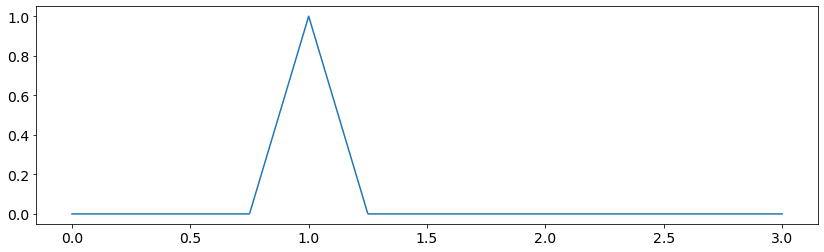

In [7]:
if __name__ == '__main__':
    def H(f, scale=1):
        return np.maximum(1 - 4 * np.abs(np.imag(f) - 1) / scale, 0)

    f = np.linspace(0, 3, 1000)
    plt.plot(f, H(1j * f));

Using the bilinear transform with pre-warping, we can move the equivalent discrete-time frequency response over the $[0, \pi]$ interval.

In [8]:
if __name__ == '__main__':
    def BL(z, c=1):
        return c * (1 - 1/z) / (1 + 1/z)

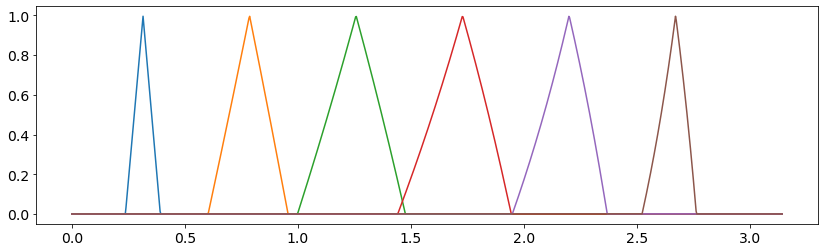

In [9]:
if __name__ == '__main__':
    w = np.linspace(0, np.pi, 1000)
    center_freqs = np.pi * np.arange(0.1, 0.9, 0.15)

    for w0 in center_freqs:
        c = 1 / np.tan(w0 / 2)
        plt.plot(w, H(BL(np.exp(1j * w), c=c)))

Note that the nonlinear mapping between frequency axes has two consequences on the the discrete-time frequency response:
 * at low and high digital frequencies the response becomes more narrow; this can be compensated for by scaling the analog prototype
 * as we move to higher frequencies, the response is less and less symmetric; this is much harder to compensate for because it would require a different analog design and it is therefore an accepted tradeoff.
 
The following example tries to keep the width of the response uniform

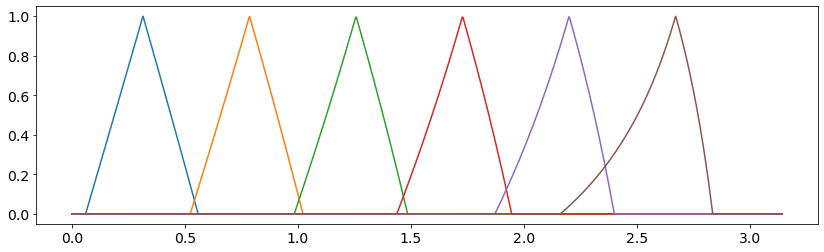

In [117]:
if __name__ == '__main__':
    for w0 in center_freqs:
        c = 1 / np.tan(w0 / 2)
        scaling_factor = (c * c + 1) / (2 * c)
        plt.plot(w, H(BL(np.exp(1j * w), c=c), scale=scaling_factor))

**Exercise**: how was the scaling factor derived? Can you improve on it?

Using the bilinear transform with pre-warping, we can move the equivalent discrete-time frequency response over the $[0, \pi]$ interval

# What about FIRs?

FIR filters are a great tool in digital signal processing; as opposed to IIR (which can be seen as a digital adaptation of electronic filters) FIRs offer:
 * unconditional stability 
 * the possibility of a linear phase response
 * a great design algorithm (Parks-McClellan) even for arbitrary responses
 
The price for stability and linear phase is a much higher computational cost: for the same specifications, an FIR filter will require up to a hundred times more operations per sample with respect to an IIR implementation. Linear phase, however, is not terribly relevant in audio applications because of the limited phase sensitivity in the human auditory system. On the other hand, especially in real-time applications, the primary goal in audio processing is to minimize the overall processing delay; since linear phase FIRs have a symmetric impulse response, and since a well-performing filter will have a very long impulse response, the associated delay often makes FIRs difficult to use. Even if we give up linear phase and implement an asymmetric, minimum-phase FIR, the computational cost may be too high.


There are countless audiophile blogs debating the merits and demerits of FIRs in audio applications. Some of the purported negatives that are often quoted include
 * FIRs sound "cold"
 * linear phase FIRs cause pre-echos (because of their symmetric impulse response) 
 * minimum-phase FIRs exhibit excessive ringing in the impulse response

It must be said that these artefacts, if they can be noticed at all, are anyway extremely subtle and unlikely to compromise overall sound quality in a significant way. The major obstacle to the use of FIRs remains their inherent processing delay.

# The cookbook

In the following, we define a set of functions that return the five biquad coefficients for the most common types of audio filtering applications. Many of the formulas have been adapted from Robert Bristow-Johnson's famous [cookbook](https://webaudio.github.io/Audio-EQ-Cookbook/audio-eq-cookbook.html). 

Each function returns ``b`` and ``a``, two arrays of three floats each containing the coefficients of the transfer function

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}} \qquad (a_0 = 1)
$$

## Lowpass

A second-order lowpass filter section will have a passband with approximately unit gain (0 dB) and a monotonically decreasing stopband. It is defined by two parameters:

 1. the "quality factor" $Q$, which determines the shape of the magnitude response; by default $Q = \sqrt{1/2}$, which yields a Butterworth characteristic (i.e. a monotonically decreasing response). 
 1. the  _corner frequency_ $f_c$ (also called the _cutoff_ frequency); the magnitude response will be equal to the quality factor $Q$ at $f_c$ and will decrease monotonically afterwards. For $Q = \sqrt{1/2}$, the attenuation at $f_c$ is equal to $20\log_{10}(\sqrt{1/2}) \approx -3$ dB, which yields a Butterworth (maximally flat) characteristic.


In [9]:
def LPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad lowpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 - c) / 2, 1 - c, (1 - c) / 2])
    return b / a[0], a / a[0]

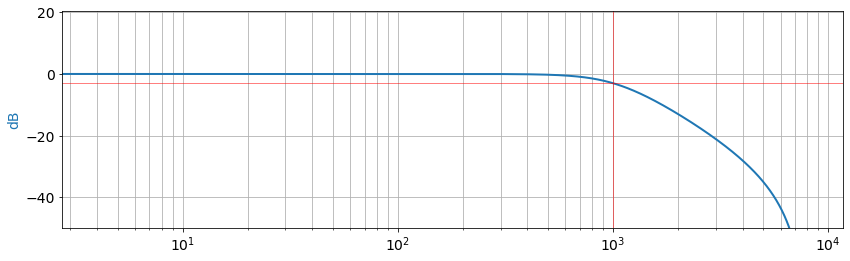

In [10]:
if __name__ == '__main__':
    CUTOFF = 1000
    b, a = LPF(CUTOFF, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-50)
    plt.axhline(y=-3, linewidth=0.5, color='r')    
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')

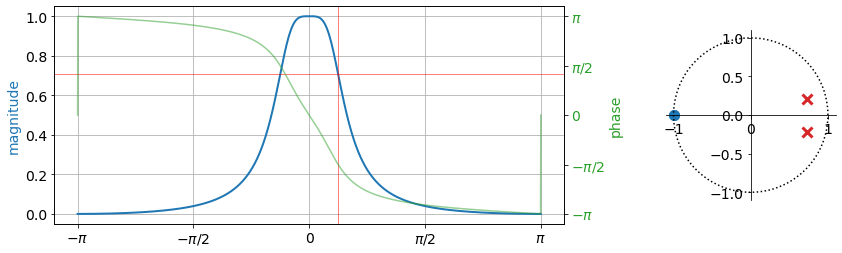

In [11]:
if __name__ == '__main__':
    filter_props(b, a)
    plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
    plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CUTOFF / DEFAULT_SF), linewidth=0.5, color='r')

When $Q = 1/\sqrt{2}$, as we said, the lowpass section corresponds to a Butterworth filter, that is, a filter with a maximally flat passband and a monotonically decreasing stopband. For higher $Q$ values the magnitude response exhibits a peak around $f_c$ which, in the time domain, corresponds to a damped oscillatory impulse response as shown in the following examples; for lower $Q$ values, the roll-off of the magnitude response will be less steep.

While these $Q$ values are clearly not a good choice for a single-stage lowpass, values other than $1/\sqrt{2}$ become useful when cascading multiple sections, as we will see later.

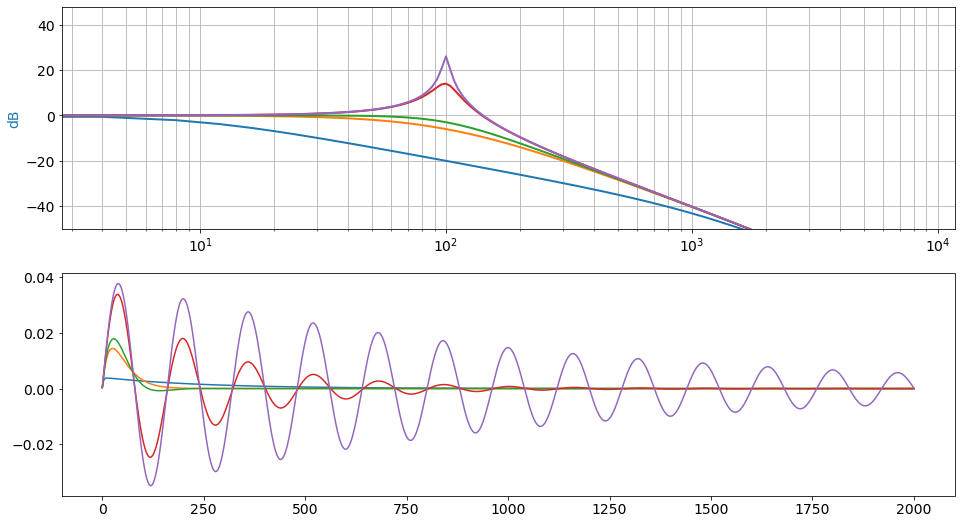

In [12]:
if __name__ == '__main__':
    _, (fr, ir) = plt.subplots(2, figsize=(16,9))
    CUTOFF = 100
    Q = [0.1, 0.5, 1/np.sqrt(2), 5, 20]
    for n, q in enumerate(Q):
        b, a = LPF(CUTOFF, DEFAULT_SF, Q=q)
        analog_response(b, a, DEFAULT_SF, dB=-50, axis=fr, color=f'C{n}')
        ir.plot(signal.lfilter(b, a, np.r_[1, np.zeros(2000)]))

## Highpass

A highpass filter is simply the complementary filter to a lowpass, with the same roles for $f_c$ and $Q$.

In [13]:
def HPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad highpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 + c) / 2, -1 - c, (1 + c) / 2])
    return b / a[0], a / a[0]

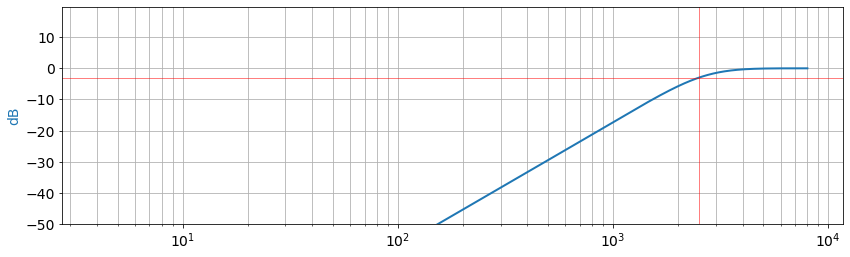

In [14]:
if __name__ == '__main__':
    CUTOFF = 2500
    b, a = HPF(CUTOFF, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-50)
    plt.axhline(y=-3, linewidth=0.5, color='r')    
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')

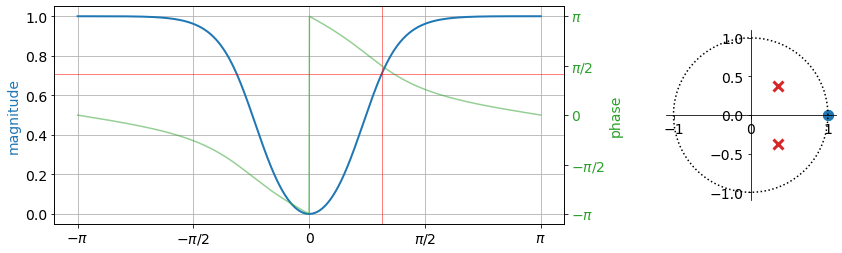

In [15]:
if __name__ == '__main__':
    filter_props(b, a)
    plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
    plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CUTOFF / DEFAULT_SF), linewidth=0.5, color='r')

## Bandpass

A second-order bandpass filter section will have approximately unit gain (0 dB) in the passband and will decrease monotonically to zero in the stopband. It is defined by two parameters:

 1. the center frequency $f_c$, where the gain is unitary
 1. the bandwidth $b = (f_+ - f_-)$, where $f_- < f_c < f_+$ are the first frequencies, left and right of $f_c$ where the attenuation reaches $-3$ dB. For the reasons explained above, note that the passband is almost but not exactly symmetric around $f_c$, with the asymmetry more pronounced towards the high end of the spectrum.

In [16]:
def BPF(fc, bw, sf):
    """Biquad bandpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([alpha, 0, -alpha])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

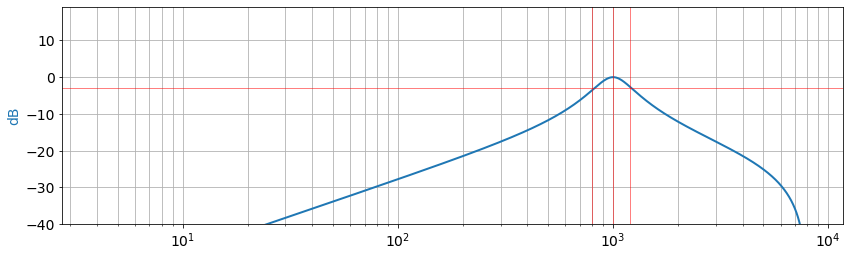

In [17]:
if __name__ == '__main__':
    CENTER, BANDWIDTH = 1000, 400
    b, a = BPF(CENTER, BANDWIDTH, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-40)
    plt.axhline(y=-3, linewidth=0.5, color='r')    
    plt.axvline(x=CENTER, linewidth=0.5, color='r')
    plt.axvline(x=CENTER - BANDWIDTH / 2, linewidth=0.5, color='r')
    plt.axvline(x=CENTER + BANDWIDTH / 2, linewidth=0.5, color='r')

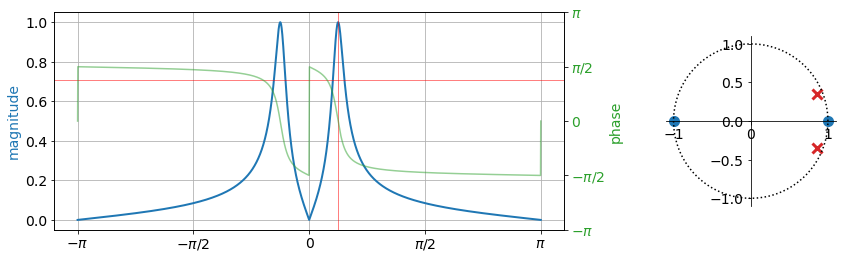

In [18]:
if __name__ == '__main__':
    filter_props(b, a)
    plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
    plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CENTER / DEFAULT_SF), linewidth=0.5, color='r')

## Resonator

When the bandwith is very small, the second order bandpass becomes a constant-gain resonator:

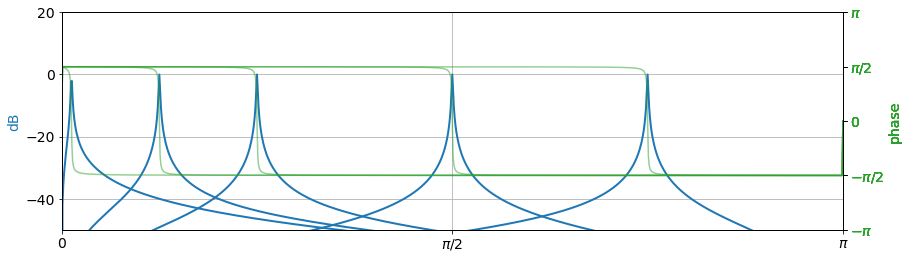

In [19]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    BANDWIDTH = 10
    FC = [100, 1000, 2000, 4000, 6000]
    for n, fc in enumerate(FC):
        b, a = BPF(fc, BANDWIDTH, DEFAULT_SF)
        frequency_response(b, a, dB=-50, half=True, axis=ax)

## Notch

A notch filter is the complementary filter to a resonator; its attenuation reaches $-\infty$ at $f_c$ and its bandwidth is usually kept very small in order to selectively remove only a given frequency; this is achieved by placing a pair of complex-conjugate zeros _on_ the unit circle and by placing two poles very close to the zeros.

In [20]:
def notch(fc, bw, sf):
    """Biquad notch filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1, -2 * c, 1])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

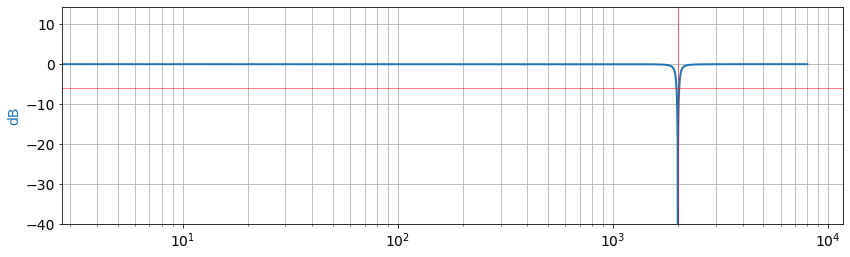

In [21]:
if __name__ == '__main__':
    CENTER, BANDWIDTH = 2000, 100
    b, a = notch(CENTER, BANDWIDTH, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-40)
    plt.axhline(y=-6, linewidth=0.5, color='r')    
    plt.axvline(x=CENTER, linewidth=0.5, color='r')

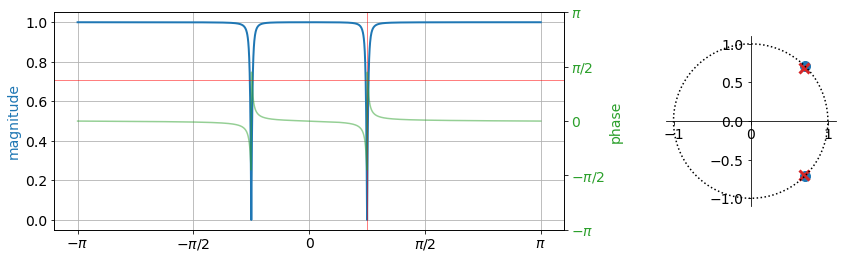

In [22]:
if __name__ == '__main__':
    filter_props(b, a)
    plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
    plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CENTER / DEFAULT_SF), linewidth=0.5, color='r')

## Shelves

Shelving filters are used to amplify either the low or the high end of a signal's spectrum. A high shelf, for instanance, provides an arbitrary gain for high frequencies and has approximately unit gain in the low end of the spectrum. Shelving filters, high or low, are defined by the following parameters:

 1. the desired _shelf gain_ in dB
 1. the midpoint frequency $f_c$, which corresponds to the frequency in the transition band where the gain reaches half its value.
 1. the "quality factor" $Q$, which determines the steepnes off the transition band; as for lowpass filters, the default value $Q = 1/\sqrt{2}$ yields the steepest transition band while avoiding resonances.
 
A common use case for shelving filters is in consumer audio appliances, where the standard "Bass" and "Treble" tone knobs control the gain of two complementary shelves with fixed midpoint frequency. 

In [23]:
def LSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad low shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  2 * A * ((A - 1) - (A + 1) * c),
                  A * ((A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 -2 * ((A - 1) + (A + 1) * c),
                 (A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

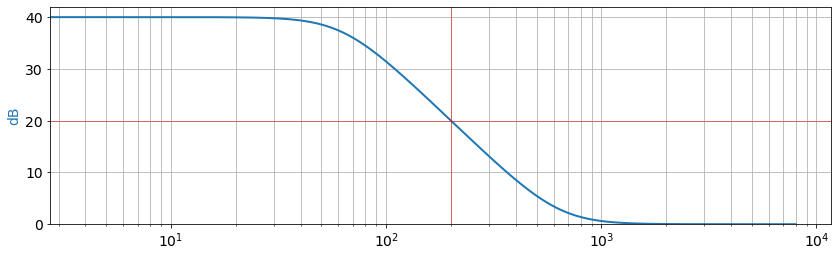

In [24]:
if __name__ == '__main__':
    MIDPOINT, GAIN_DB = 200, 40
    b, a = LSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-40)
    plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
    plt.axvline(x=MIDPOINT, linewidth=0.5, color='r')

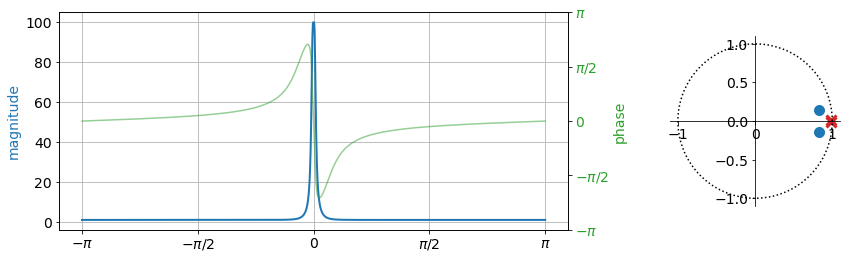

In [25]:
if __name__ == '__main__':
    filter_props(b, a)

In [26]:
def HSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad high shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  -2 * A * ((A - 1) + (A + 1) * c),
                  A * ((A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 2 * ((A - 1) - (A + 1) * c),
                 (A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

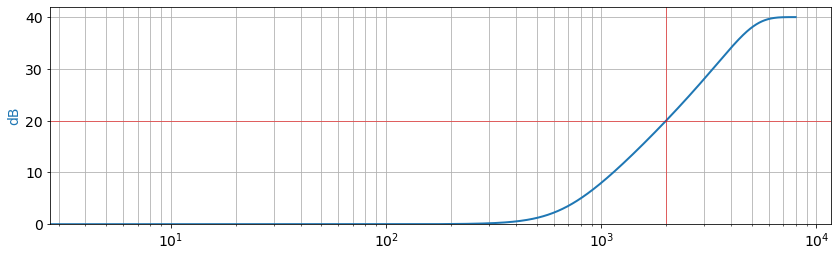

In [27]:
if __name__ == '__main__':
    MIDPOINT, GAIN_DB = 2000, 40
    b, a = HSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-40)
    plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
    plt.axvline(x=MIDPOINT, linewidth=0.5, color='r')

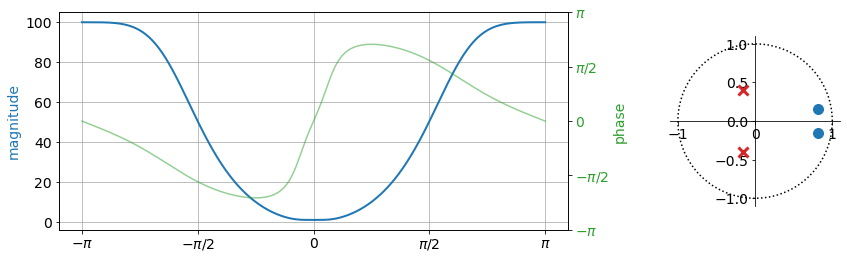

In [28]:
if __name__ == '__main__':
    filter_props(b, a)

## Peaking EQ

A peaking equalizer filter is the fundamental ingrediend in multiband parametric equalization. Each filter provides an arbitrary boost or attenuation for a given frequency band centered around a peak freqency and flattens to unit gain elsewhere. The filter is defined by the following parameters:

 1. the desired gain in dB (which can be negative)
 1. the peak frequency $f_c$, where the desired gain is attained
 1. the bandwidth of the filter, defined as the interval around $f_c$ where the gain is greater (or smaller, for attenuators) than half the desired gain in dB; for instance, if the desired gain is 40dB, all frequencies within the filter's bandwidth will be boosted by at least 20dB. Note that the bandwdidth is not exactly symmetrical around $f_c$ 

In [29]:
def PEQ(fc, bw, gain, sf):
    """Biquad bandpass filter """
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1 + alpha * A, -2 * c, 1 - alpha * A])
    a = np.array([1 + alpha / A, -2 * c, 1 - alpha / A])
    return b / a[0], a / a[0]

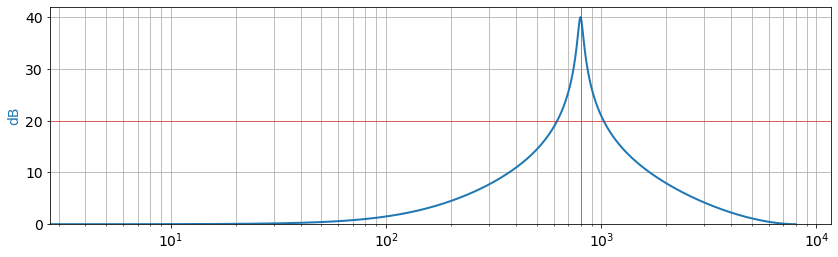

In [30]:
if __name__ == '__main__':
    CENTER, BW, GAIN_DB = 800, 400, 40
    b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-40)
    plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
    plt.axvline(x=CENTER, linewidth=0.5, color='r')

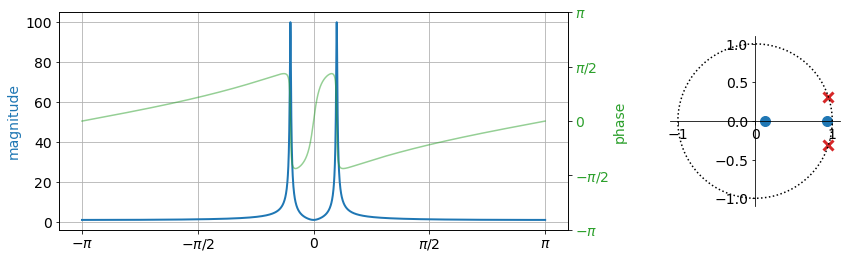

In [31]:
if __name__ == '__main__':
    filter_props(b, a)

Note that peaking EQ filters with opposite gains are perfectly complementary: 

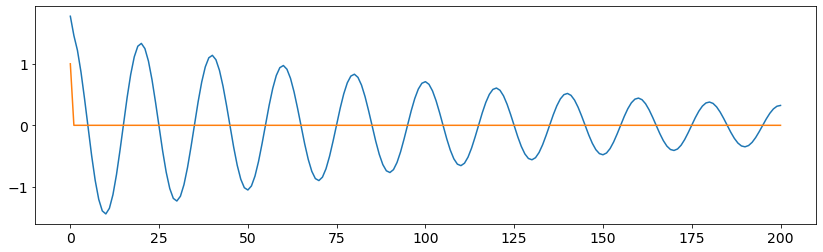

In [32]:
if __name__ == '__main__':
    CENTER, BW, GAIN_DB = 800, 400, 40
    b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
    y = signal.lfilter(b, a, np.r_[1, np.zeros(200)])
    plt.plot(y)
    b, a = PEQ(CENTER, BW, -GAIN_DB, DEFAULT_SF)
    y = signal.lfilter(b, a, y)
    plt.plot(y)

# Cascades of biquads

The performance of a single biquad filter may not be adequate for a given application: a second-order lowpass filter, for instance, may not provide a sufficent amount of rejection in the stopband because of its rather slow roll-off characteristic; or we may want to design an equalizer with multiple peaks and dips. In all cases, we usually want to implement the final design as a cascade of biquad sections, because of their inherent numerical robustness.

## Factorization of higher-order filters

The first solution if a filter does not meet the requires specifications is to design a higher-order filter, possibly using different filter "recipes"; in the case of bandpass filters, for instance, we could try a Chebyshev or elliptic design. The resulting high-order transfer function can be then factored into a cascade of second-order sections (or, in the case of an odd-order filter, a cascade of second order-sections followed by a first-order filter):

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{a_0 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}} = \prod_{k=0}^{N/2} \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}{1 + a_{k,1} z^{-1} + a_{k,2}z^{-2}}
$$

The biquad elements returned by the factorization are not related to the "cookbook" prototypes of the previous section and therefore this method is simply an implementation strategy that focuses on second-order structures; the design algorithm, in other words, will be dependent on the particular type of filter. Nevertheless, both the design and the factorization are usually available in numerical packages such as Scipy, for instance and, in the following example, we illustrate the difference between a 6th-order elliptic lowpass and a single second-order butterworth. First we will use the full high-order realization and then we will show how a cascade of three second-order sections implements the same characteristic.

Note that, when cascading transfer functions, the equivalent higher-order filter coefficients can be obtained simply by polynomial multiplication.

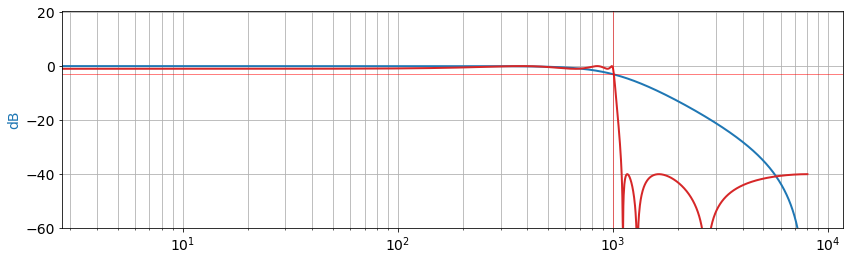

In [33]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    CUTOFF = 1000
    b, a = LPF(CUTOFF, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C0')
    eb, ea = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF)
    analog_response(eb, ea, DEFAULT_SF, dB=-60, axis=ax, color=f'C3')
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
    plt.axhline(y=-3, linewidth=0.5, color='r')     

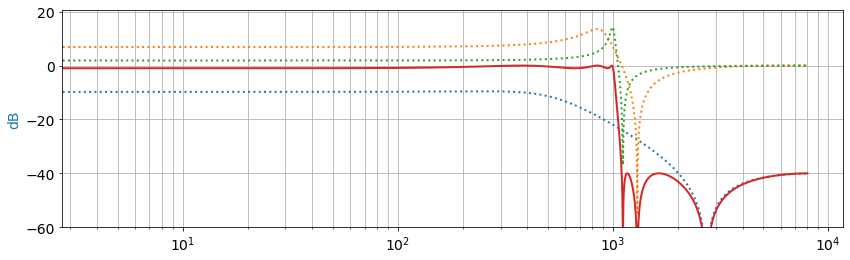

In [34]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    CUTOFF = 1000
    b, a = LPF(CUTOFF, DEFAULT_SF)
    # this returns an array of second-order filter coefficients. Each row corresponds to a section, 
    #  with the first three columns providing the numerator coefficients and the last three providing the denominator
    soe = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF, output='sos')
    cb, ca = [1], [1]
    for n in range(0, 3):
        b, a = soe[n][0:3], soe[n][3:6]
        analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}:')
        cb = np.polymul(b, cb)
        ca = np.polymul(a, ca)
    analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C3')

## Cascading lowpass and highpass biquads

A cascade of $N$ identical sections with transfer function $H(z)$ will yield the overall transfer function $H_c(z) = H^N(z)$ and thus the stopband attenuation in decibels will increase $N$-fold. For instance, the following example shows the cumulative magnitude responses obtained by cascading up to five identical second-order Butterworth lowpass sections:

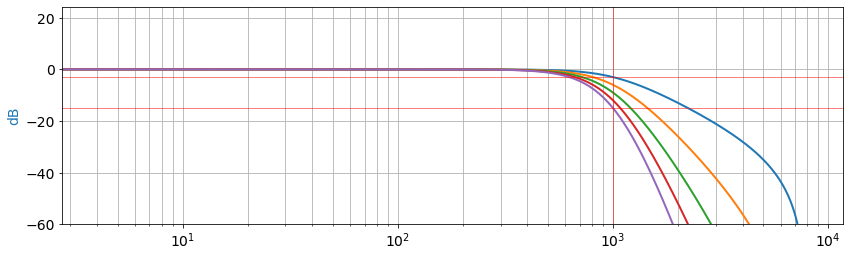

In [35]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    CUTOFF = 1000
    b, a = LPF(CUTOFF, DEFAULT_SF)
    cb, ca = b, a
    for n in range(0, 5):
        analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}')
        ca = np.polymul(a, ca)
        cb = np.polymul(b, cb)
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
    plt.axhline(y=-3, linewidth=0.5, color='r')    
    plt.axhline(y=-15, linewidth=0.5, color='r')    

As shown by the previous plot, a cascade of identical maximally flat lowpass sections yields a steeper roll-off and preserves the monotonicity of the response. However, since the passband of each filter is not perfectly flat, the $-3~\mathrm{dB}$ cutoff frequency of the cascade becomes smaller with each added section and the effective bandwidth of the filter is reduced. In the previous example, the original $-3~\mathrm{dB}$ cutoff frequency was $f_c = 1000~\mathrm{Hz}$ but the magnitude response of the cascade at $f_c$ is $-15~\mathrm{dB}$ whereas the actual $-3~\mathrm{dB}$ point has shifted close to $600~\mathrm{Hz}$.

If our goal is to obtain a cascade with a maximally flat (Butterworth) response with a given $f_c$, an obvious approach is simply to factorize the transfer function of a high-order Butterworth as explained in the previous section. There is however a clever and simpler design strategy that is based on the geometric arrangement of the poles of an analog Butterworth filter of order $N$:
 * the $N$ complex-conjugate poles are equally spaced along a circular contour centered on the origin of the $s$-plane
 * the angle between poles is equal to $\pi/N$
 
With this, the pole angles in the upper $s$-plane are given by 

$$
    \theta_n = \frac{\pi}{2N} + n\frac{\pi}{N} = \frac{(2n+1)\pi}{2N}, \qquad n = 0, \ldots, N/2
$$

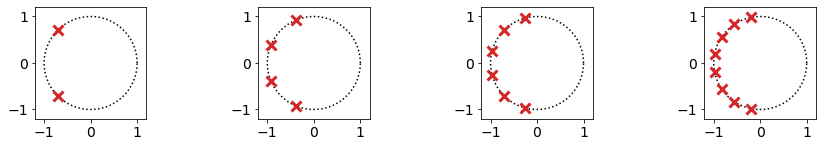

In [36]:
if __name__ == '__main__':
    fig, sp = plt.subplots(1, 4, gridspec_kw={'wspace': 1})
    for n in range(0, 4):
        sp[n].plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'k:')
        p = np.roots(signal.butter(2 * (n + 1), 1, analog=True)[1])
        sp[n].plot(p.real, p.imag, 'C3x', ms=10, markeredgewidth=3.0)
        sp[n].axis('square')
        sp[n].set_xlim(-1.2, 1.2)        
        sp[n].set_ylim(-1.2, 1.2)

Now, a generic second-order analog filter will have a single pair of complex-conjugate poles at $p_{1,2} = \rho e^{\pm \theta}$ on the $s$-plane and, by cascading identical sections, we will only manage to increase the poles' multiplicity but we will not be able to change their position. In order to achieve a Butterworth pole configuration we will thus need to adjust the pole angle for each section; this is a simple task because it turns out that a second-order filter's quality factor $Q$ is related to the pole angle as 
$$
    1/Q = 2\cos \theta
$$ 
which means that we can choose the suitable pole angle for each section simply by setting $Q_n = 1/(2\cos \theta_n)$. We can now design $N/2$ discrete-time biquads with the same $Q_n$ values to obtain the desired result.

Below is the example for a cascade of five lowpass sections (i.e. a  10th-order filter) compared to a single biquad, both with cutoff $f_c = 1000~\mathrm{Hz}$; notice how the $-3~\mathrm{dB}$ point has not moved in spite of the much steeper rolloff.

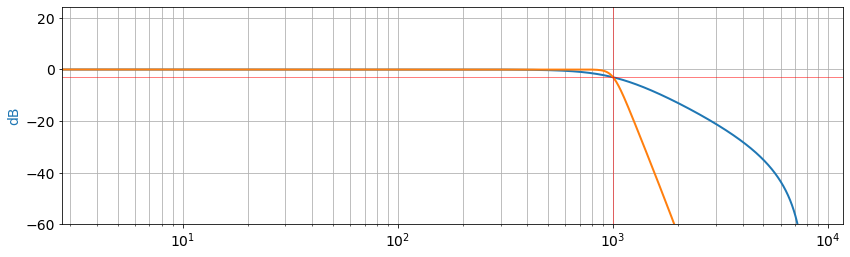

In [37]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    CUTOFF = 1000
    b, a = LPF(CUTOFF, DEFAULT_SF)
    analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color='C0')
    cb, ca, sections = [1], [1], 5
    for n in range(0, sections):
        iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
        b, a = LPF(CUTOFF, DEFAULT_SF, Q=1/iq)
        ca = np.polymul(a, ca)
        cb = np.polymul(b, cb)
    analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1')
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
    plt.axhline(y=-3, linewidth=0.5, color='r')    

The resulting digital filter has its poles arranged on a circular contour centered in $z=1$ if the cutoff frequency is less than $\pi/2$ and centered on $z=-1$ otherwise. 

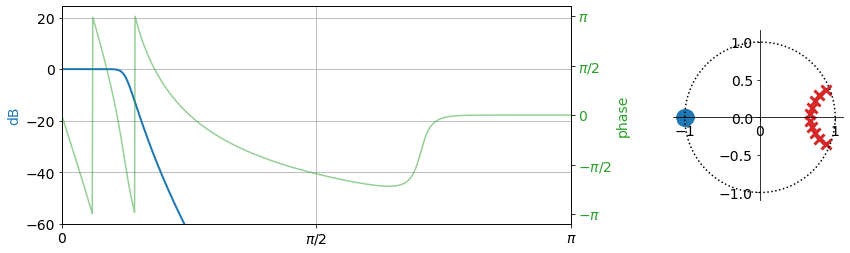

In [38]:
if __name__ == '__main__':
    filter_props(cb, ca, DEFAULT_SF, dB=-60)

Finally, the following plot shows the individual magnitude responses of the five sections. You can observe that the required $Q_n$ values lead to some biquad sections with a clear peak at the cutoff frequency, although the overall response is monotonic:

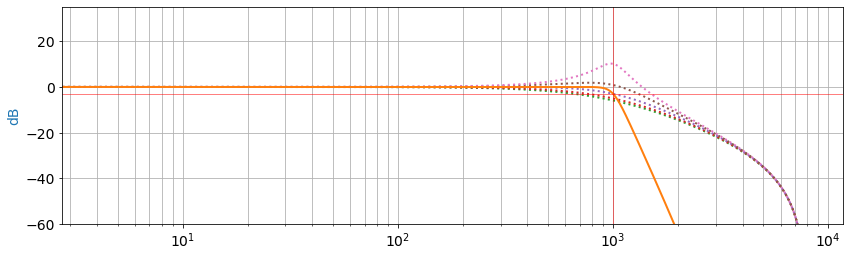

In [39]:
if __name__ == '__main__':
    _, ax = plt.subplots()
    CUTOFF = 1000
    cb, ca, sections = [1], [1], 5
    for n in range(0, sections):
        iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
        b, a = LPF(CUTOFF, DEFAULT_SF, Q=1/iq)
        analog_response(b, a, DEFAULT_SF, dB=-0, axis=ax, color=f'C{n+2}:')
        ca = np.polymul(a, ca)
        cb = np.polymul(b, cb)
    analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1')
    plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
    plt.axhline(y=-3, linewidth=0.5, color='r')    

## Combining shelving filters

Shelving filters may be combined to create filters to boost a particular frequency range

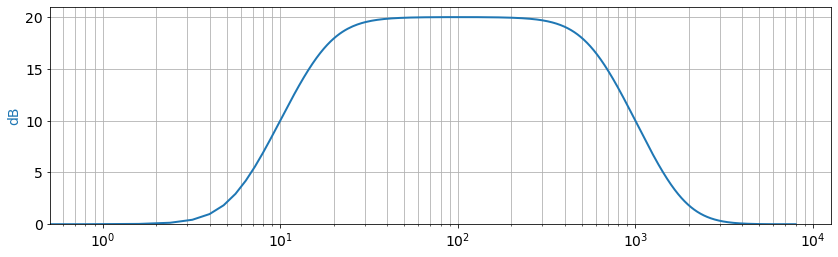

In [40]:
if __name__ == '__main__':
    cb, ca = LSH(1000, 20, DEFAULT_SF)    
    b, a = HSH(10, 20, DEFAULT_SF)
    cb = np.polymul(b, cb) 
    ca = np.polymul(a, ca)
    # normalize 
    analog_response(cb / 10, ca, DEFAULT_SF, dB=-50, points=10001)

## Parametric equalization

Peaking equalizers with distinct bandwidths can be cascaded to obtain an arbitrary equalization curve for the entire range of input frequencies; indeed, this is the technique behind so-called _parametric equalizers_ where a bank of logarithmically spaced peaking eq's with independent gain controls allow the user to easily define a global equalization response.

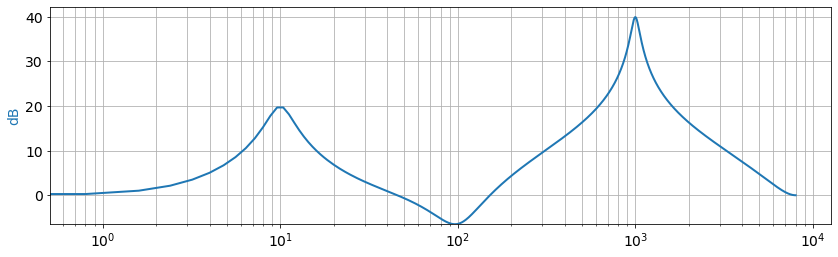

In [41]:
if __name__ == '__main__':
    cb, ca = np.ones(1), np.ones(1)
    for n, g in enumerate([20, -10, 40]):
        b, a = PEQ(10 ** (n+1), 10 ** (n + 1), g, DEFAULT_SF)
        cb = np.polymul(b, cb)
        ca = np.polymul(a, ca)
    analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001)

# Examples

# References

https://webaudio.github.io/Audio-EQ-Cookbook/audio-eq-cookbook.html